In [225]:
import pandas as pd
import numpy as np

IMPORT DATA

In [226]:
# index_col setta una colonna come index di pd.DataFrame
data: pd.DataFrame = pd.read_excel("C:/Users/andre/Desktop/Asset.xlsx", index_col="datetime")

CALC RETURNS

In [227]:
rf = 0.0001
# applica log a data e dopo fa la differenza prima con diff(); dropna() elimina i NaN dal DataFrame
# provare a stampare log_ret con e senza .dropna()
log_ret: pd.DataFrame = np.log(data).diff().dropna()

log_ret.head()

,AAPL,ABI,W5000,SP500,EUR_USD,USD_YEN
datetime,,,,,,
2009-01-05,0.041338,0.098272,-0.022958,-0.004679,0.001071,0.000738
2009-01-06,-0.016632,-0.017332,-0.024068,0.007787,-0.001357,0.001685
2009-01-07,-0.021845,-0.006007,0.003633,-0.030469,-0.011139,0.003467
2009-01-08,0.018399,0.039262,-0.035037,0.003391,0.007129,0.016641
2009-01-09,-0.023135,-0.010968,0.004174,-0.021533,0.015662,-0.016641


In [228]:
log_ret.describe().round(4)

,AAPL,ABI,W5000,SP500,EUR_USD,USD_YEN
count,2767.0000,2767.0000,2767.0000,2767.0000,2767.0000,2767.0000
mean,0.0011,0.0004,0.0005,0.0004,-0.0001,0.0000
std,0.0167,0.0153,0.0105,0.0103,0.0056,0.0058
min,-0.1319,-0.1196,-0.0733,-0.0690,-0.0265,-0.0375
25%,-0.0070,-0.0077,-0.0037,-0.0035,-0.0033,-0.0030
50%,0.0010,0.0003,0.0006,0.0007,0.0000,0.0000
75%,0.0102,0.0087,0.0055,0.0053,0.0030,0.0031
max,0.0850,0.0983,0.0677,0.0684,0.0302,0.0346


DEFINES INPUT FOR REGRESSION

In [229]:
Y: pd.DataFrame = log_ret.loc[:, ["AAPL"]] - rf # usare [] quando si selezionano le colonne per ottenere un pd.DataFrame 
X: pd.DataFrame = log_ret.loc[:, ["SP500", "EUR_USD"]]  # seleziona mkt factor e tasso cambio

X.loc[:, "SP500"] = X.loc[:, "SP500"] - rf  # sostituisce mkt factor con mkt factor - risk_free
# ALTERNATIVA: X.loc["SP500"] -= rf
X['constant'] = 1  # aggiunge una colonna di 1 IN ULTIMA POSIZIONE

X: pd.DataFrame = X.loc[:, ["constant", "SP500", "EUR_USD"]]  # ri-definisco X come X che segue un'ordinamento delle colonne specifico

In [230]:
Y.head()

,AAPL
datetime,
2009-01-05,0.041238
2009-01-06,-0.016732
2009-01-07,-0.021945
2009-01-08,0.018299
2009-01-09,-0.023235


In [232]:
X.head()

,constant,SP500,EUR_USD
datetime,,,
2009-01-05,1,-0.004779,0.001071
2009-01-06,1,0.007687,-0.001357
2009-01-07,1,-0.030569,-0.011139
2009-01-08,1,0.003291,0.007129
2009-01-09,1,-0.021633,0.015662


CALC REGRESSION'S COEFFICIENTS

In [233]:
coeffs: pd.DataFrame = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ Y
coeffs.index = X.columns  # oltre al matching tra (rows, columns) matriciale; deve matchare anche il nome delle righe con quello delle colonne
coeffs

,AAPL
constant,0.000682
SP500,0.993171
EUR_USD,0.014083


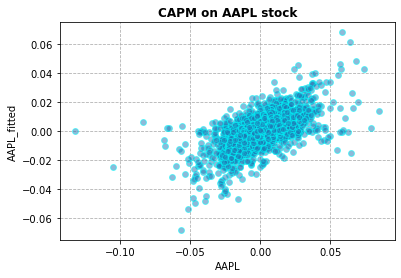

In [234]:
Y_hat: pd.DataFrame = X @ coeffs

plt.figure()
plt.scatter(x=Y, y=Y_hat, alpha=0.5, edgecolor='cyan')
plt.plot()

plt.xlabel("AAPL")
plt.ylabel("AAPL_fitted")
plt.grid(linestyle='dashed')
plt.title("CAPM on AAPL stock", fontweight='bold')

plt.show()

# super estetica, utilizzare libreria seaborn

In [235]:
err: pd.DataFrame = Y - Y_hat
# SSE = np.sum(err ** 2)
SSE: np.array = (err.transpose() @ err).values
# np.var(err ** 2)
# var_e = (err ** 2).var()  #non fa diviso n-k
var_e: np.array = (np.sum((err**2 - np.mean(err**2))**2) / len(err - X.shape[1])).values  # la più precisa
std_e: np.array = var_e ** (1/2)


In [236]:
varcov: np.array = np.linalg.inv(X.transpose() @ X) * var_e
varcov

array([[ 1.12890977e-10, -3.71509956e-10,  2.80248007e-10],
       [-3.71509956e-10,  1.06993868e-06,  2.84175195e-08],
       [ 2.80248007e-10,  2.84175195e-08,  3.62196071e-06]])

In [237]:
variances = np.diag(varcov)
variances

array([1.12890977e-10, 1.06993868e-06, 3.62196071e-06])

In [238]:
coeffs["T-stat"] = coeffs["AAPL"].values / variances
coeffs

,AAPL,T-stat
constant,0.000682,6.039497e+06
SP500,0.993171,9.282505e+05
EUR_USD,0.014083,3.888119e+03


In [263]:
from scipy.stats import t as t_student

t_stat_beta_mkt: float = coeffs.loc["SP500", "T-stat"] 
t_stat_beta_fx: float = coeffs.loc["EUR_USD", "T-stat"]
T: int = X.shape[0]
k: int = X.shape[1]
    
critical_value: float = np.abs(t_student.ppf(q=1 - 0.05/2, df=T-k))
    
print('Beta SP500 t-value: ', t_stat_beta_mkt)
print('Beta EUR/USD t-value: ', t_stat_beta_fx)

print('\nCritical Value t-student (a=0.05): ', critical_value)

if t_stat_beta_mkt > critical_value:
    print('\nfico, la regressione funzione')
else:
    print("\nnoooo, mi do all'ippica")

Beta SP500 t-value:  928250.5288518186
Beta EUR/USD t-value:  3888.1190908555154

Critical Value t-student (a=0.05):  1.960822628798158

fico, la regressione funzione
